# Create the dataset required for SLICE

## Unpack the polygons for France data

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

path_gpkg = "./france/PARCELLES_GRAPHIQUES.gpkg"

# Load the data
data = gpd.read_file(path_gpkg)
data = data.to_crs("EPSG:4326")

## Sample Polygons to create the dataset

### Choice 1: Randomly sample points from the data
**Warning**: This method will require almost the whole france planet mosiacs which could end up in TBs

In [ ]:
"""
points = data.sample(10000)
"""

### Choice 2: Select points from an ROI that has diverse plots
Randomly select 10000 points from data and save them to data/france/points.gpkg

In [2]:
# ROI of sampled points precise repetability
roi1 = Polygon([
        [1.007196,46.92429200000001],
        [1.453411,46.92429200000001],
        [1.453411,47.48712699999999],
        [1.007196,47.48712699999999]
])

roi2 = Polygon([
        [3.391409,48.73079899999996],
        [3.883134,48.73079899999996],
        [3.883134,49.373379],
        [3.391409,49.373379]
])

roi3 = Polygon([
        [4.645017,44.618415],
        [5.1856,44.618415],
        [5.1856,45.437524000000025],
        [4.645017,45.437524000000025]
])
 
data1 = data[data.within(roi1)]
data2 = data[data.within(roi2)]
data3 = data[data.within(roi3)]
# sampled = data.sample(10000)

# Save the sampled points for training and testing
# sampled.to_file("data/france/sampled.gpkg", driver="GPKG")

## Load Kenya Data

In [22]:
import os
from shapely.geometry import Polygon, MultiPolygon
aois = sorted(os.listdir('./rwanda/aois'))
labels = sorted(os.listdir('./rwanda/labels'))

dfl = []
for idx in range(len(aois)):
    data5 = gpd.read_file('./rwanda/labels/' + labels[idx])
    if len(data5) == 0:
        continue
    for polygon in data5.geometry.tolist():
        df2 = {
            'ID_PARCEL':  data5.iloc[0]['aoi_id'],
            'geometry': MultiPolygon([polygon]),
        }
        dfl.append(df2)

dfl = gpd.GeoDataFrame.from_dict(dfl)

In [23]:
# Concat all the data to a single file

all_data = pd.concat([
    data1[['ID_PARCEL', 'geometry']],
    data2[['ID_PARCEL', 'geometry']],
    data3[['ID_PARCEL', 'geometry']],
    dfl
]).reset_index()
# all_data.drop(['index'])
all_data = all_data[['ID_PARCEL', 'geometry']]
all_data.to_file("all_data.gpkg", driver="GPKG")

/home/mcsatish/.local/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


## Extract images

In [1]:
import os
import shutil
import cv2
import numpy as np
import geopandas as gpd
import tensorflow as tf
from pyunpack import Archive
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

BASE_DIR = "france/"

path = BASE_DIR + "gz_files/"
tf_out_path = BASE_DIR + "tf_files/"

if os.path.exists(tf_out_path):
    print("Removing Existing Directory.....")
    shutil.rmtree(tf_out_path)

print("Creating TFRECORD Exctract Directory.....")
os.makedirs(tf_out_path)
    
gz_files = os.listdir(path)
gz_files = [f for f in gz_files if f.endswith('.gz')]

for i in gz_files:
    Archive(path+i).extractall(tf_out_path)

print(">>>>>>>>>> Extraction Complete <<<<<<<<<<<<")
    
img_out_path = BASE_DIR + "all_dataset/"
if os.path.exists(img_out_path):
    print("Removing Existing Image Directory.....")
    shutil.rmtree(img_out_path)

print("Creating IMAGE Exctract Directory.....")
os.makedirs(img_out_path)

tf_files = [tf_out_path + f for f in os.listdir(tf_out_path)]

2023-05-13 16:12:25.774431: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Removing Existing Directory.....
Creating TFRECORD Exctract Directory.....
>>>>>>>>>> Extraction Complete <<<<<<<<<<<<
Removing Existing Image Directory.....
Creating IMAGE Exctract Directory.....


In [26]:
# Create a new geo dataframe
df = gpd.GeoDataFrame()
df['parcel_id'] = None
df['geometry'] = None

options = tf.compat.v1.python_io.TFRecordOptions(tf.compat.v1.python_io.TFRecordCompressionType.NONE)
idx = 0
satellite_features = ['B1', 'B2', 'B3']

for tf_file in tf_files:
    print("Processing File: ", tf_file)
    for example in tf.compat.v1.python_io.tf_record_iterator(tf_file, options=options):
        ex = tf.train.Example.FromString(example)
        min_lon = min(ex.features.feature['longitude'].float_list.value) 
        max_lon = max(ex.features.feature['longitude'].float_list.value) 
        min_lat = min(ex.features.feature['latitude'].float_list.value) 
        max_lat = max(ex.features.feature['latitude'].float_list.value)

        # If any of the coordinates are zero take the second min/max
        if min_lon == 0:
            min_lon = list(set(sorted(ex.features.feature['longitude'].float_list.value)))[1]
        if max_lon == 0:
            max_lon = list(set(sorted(ex.features.feature['longitude'].float_list.value)))[-2]
        if min_lat == 0:
            min_lat = list(set(sorted(ex.features.feature['latitude'].float_list.value)))[1]
        if max_lat == 0:
            max_lat = list(set(sorted(ex.features.feature['latitude'].float_list.value)))[-2]


        geometry = Polygon([
            [min_lon, min_lat],
            [min_lon, max_lat],
            [max_lon, max_lat],
            [max_lon, min_lat]
        ])

        # Calculate the area
        # if geometry.area > 1:
        #     continue


        features = []
        for satellite_feature in satellite_features:
            feature = (ex.features.feature[satellite_feature].float_list.value)
            feature = np.array(feature)
            feature = feature.reshape((448, 448, 1))
            # feature = np.flip(feature, axis=0)
            features.append(feature)
            
        image = np.concatenate(features, axis=2)
        # image = image/np.max(image) # Normalization
        # But using 2188 has more clarity
        image = image/2188

        # Save the image
        image_name = img_out_path + f"{idx:04d}" + ".png"
        
        cv2.imwrite(image_name, image*255)

        # Save the geo data
        df.loc[idx, 'parcel_id'] = f"{idx:04d}"
        df.loc[idx, 'geometry'] = geometry
        
        idx += 1

# df.to_file(img_out_path + "geo_data.geojson", driver="GeoJSON")

Processing File:  france/tf_files/ps_france_3-00035.tfrecord
Processing File:  france/tf_files/ps_france_3-00043.tfrecord
Processing File:  france/tf_files/ps_france_1-00029.tfrecord
Processing File:  france/tf_files/ps_france_2-00000.tfrecord
Processing File:  france/tf_files/ps_france_3-00032.tfrecord
Processing File:  france/tf_files/ps_france_1-00026.tfrecord
Processing File:  france/tf_files/ps_france_2-00020.tfrecord
Processing File:  france/tf_files/ps_france_3-00002.tfrecord
Processing File:  france/tf_files/ps_france_3-00041.tfrecord
Processing File:  france/tf_files/ps_france_3-00055.tfrecord
Processing File:  france/tf_files/ps_france_3-00077.tfrecord
Processing File:  france/tf_files/ps_france_2-00042.tfrecord
Processing File:  france/tf_files/ps_france_2-00076.tfrecord
Processing File:  france/tf_files/ps_france_2-00012.tfrecord
Processing File:  france/tf_files/ps_france_3-00070.tfrecord
Processing File:  france/tf_files/ps_france_3-00086.tfrecord
Processing File:  france

6884

In [28]:
df.to_file(img_out_path + "parcel_data.geojson", driver="GeoJSON")
df

,parcel_id,geometry
0,0000,"POLYGON ((5.00722 45.18434, 5.00722 45.19638, ..."
1,0001,"POLYGON ((5.01930 45.18434, 5.01930 45.19638, ..."
2,0002,"POLYGON ((5.03137 45.18434, 5.03137 45.19638, ..."
3,0003,"POLYGON ((5.04344 45.18434, 5.04344 45.19638, ..."
4,0004,"POLYGON ((5.05552 45.18434, 5.05552 45.19638, ..."
...,...,...
6879,6879,"POLYGON ((4.77783 45.24471, 4.77783 45.25675, ..."
6880,6880,"POLYGON ((4.78990 45.24471, 4.78990 45.25675, ..."
6881,6881,"POLYGON ((4.80198 45.24471, 4.80198 45.25675, ..."
6882,6882,"POLYGON ((4.81405 45.24471, 4.81405 45.25675, ..."


In [31]:
# roi = Polygon([
#             [-0.7155534667066932, 43.39057963239615],
#             [-0.7155534667066932, 43.156608691390645],
#             [0.34359722909410806, 43.156608691390645],
#             [0.34359722909410806, 43.39057963239615]
# ])

# path_gpkg = "./france/refined.gpkg"

# # Load the data
# data = gpd.read_file(path_gpkg)
# data = data[data.within(roi)]
all_data

,ID_PARCEL,geometry
0,20011363,"MULTIPOLYGON (((1.01090 46.94813, 1.00914 46.9..."
1,17420746,"MULTIPOLYGON (((1.02797 47.01545, 1.02627 47.0..."
2,14956487,"MULTIPOLYGON (((1.02500 47.22271, 1.02702 47.2..."
3,17420346,"MULTIPOLYGON (((1.08344 47.06893, 1.08520 47.0..."
4,3791446,"MULTIPOLYGON (((1.09042 46.93826, 1.08854 46.9..."
...,...,...
186066,1592683,"MULTIPOLYGON (((30.30433 -1.39439, 30.30492 -1..."
186067,1592683,"MULTIPOLYGON (((30.31378 -1.39194, 30.31359 -1..."
186068,1592683,"MULTIPOLYGON (((30.30897 -1.40111, 30.30958 -1..."
186069,1592683,"MULTIPOLYGON (((30.30747 -1.39989, 30.30817 -1..."


In [32]:
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

dfx = df.copy()
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Calculate the centroid of data
all_data['centroid'] = all_data['geometry'].centroid
dfx['parcels'] = None

# Iterate over the data
for idx, row in dfx.iterrows():
    if idx % 100 == 0:
        print("Processing: ", idx)
    # Get the centroids that lie inside the row's geometry
    centroids = all_data[all_data['centroid'].within(row['geometry'])].copy()
    # Drop all columns except the geometry
    centroids = centroids.drop(columns=['centroid'])
    # save to geojson
    centroids.to_file(img_out_path + row['parcel_id'] + ".geojson", driver="GeoJSON")

# dfx

Processing:  0
Processing:  100
Processing:  200
Processing:  300
Processing:  400
Processing:  500
Processing:  600
Processing:  700
Processing:  800
Processing:  900
Processing:  1000
Processing:  1100
Processing:  1200
Processing:  1300
Processing:  1400
Processing:  1500
Processing:  1600
Processing:  1700
Processing:  1800
Processing:  1900
Processing:  2000
Processing:  2100
Processing:  2200
Processing:  2300
Processing:  2400
Processing:  2500
Processing:  2600
Processing:  2700
Processing:  2800
Processing:  2900
Processing:  3000
Processing:  3100
Processing:  3200
Processing:  3300
Processing:  3400
Processing:  3500
Processing:  3600
Processing:  3700
Processing:  3800
Processing:  3900
Processing:  4000
Processing:  4100
Processing:  4200
Processing:  4300
Processing:  4400
Processing:  4500
Processing:  4600
Processing:  4700
Processing:  4800
Processing:  4900
Processing:  5000
Processing:  5100
Processing:  5200
Processing:  5300
Processing:  5400
Processing:  5500
Proc

In [34]:
def draw(img, data_in_dfx, dfx):
    # Get the image of the parcel

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Vertical flip the image using cv2
    # img = cv2.flip(img, 0)

    # Get the coordinates of the parcel
    coords = dfx.geometry.exterior.coords.xy

    # Map the lat/lons to the image

    # Get the min/max lat/lon
    min_lon = min(coords[0])
    max_lon = max(coords[0])
    min_lat = min(coords[1])
    max_lat = max(coords[1])

    # Get the width and height of the image
    img_height, img_width, _ = img.shape

    # Get the width and height of the parcel
    width = max_lon - min_lon
    height = max_lat - min_lat

    # Get the pixel width and height
    pixel_width = img_width/width
    pixel_height = img_height/height


    # Draw the multipolygon in the data_in_dfx
    for i in range(len(data_in_dfx)):
        multipolygon = data_in_dfx.iloc[i].geometry.geoms
        for polygon in multipolygon:
            coords = polygon.exterior.coords.xy

            # Get the pixel coords
            pixel_coords = []
            for i in range(len(coords[0])):
                x = coords[0][i]
                y = coords[1][i]

                # Get the pixel x and y
                pixel_x = (x - min_lon) * pixel_width
                pixel_y = (max_lat - y) * pixel_height

                pixel_coords.append([pixel_x, pixel_y])

            # Convert the pixel coords to int
            pixel_coords = np.array(pixel_coords, dtype=np.int32)

            # Draw the polygon
            cv2.polylines(img, [pixel_coords], True, (0, 255, 0), 2)

    # Show the image
    plt.imshow(img)
    # data_in_dfx.plot()

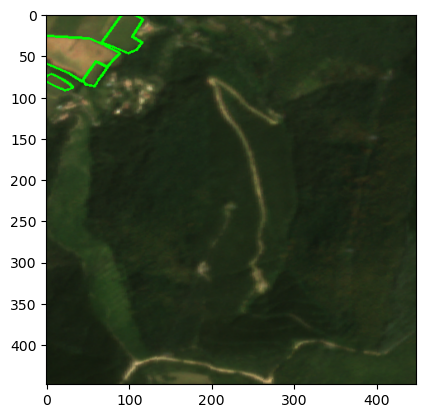

In [46]:
idx = 6794
dfx = df.iloc[idx]
data_in_dfx = gpd.read_file(img_out_path + str(idx) + ".geojson")

img = cv2.imread(img_out_path + str(idx) + ".png")

draw(img, data_in_dfx, dfx)